## Customer Personality Analysis

### Necessary Imports

In [1]:
from typing import Tuple, List, TypedDict, Callable, Sequence, Iterable, Type, NewType
from datetime import datetime, date, timedelta
from enum import Enum, auto
from dataclasses import dataclass
import math

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering

from IPython.display import display, DisplayHandle, Markdown
from tqdm.notebook import tqdm

### Dataset-specific & Helper constants

In [2]:
READ_DATASET: Callable[[], pd.DataFrame] = lambda: pd.read_csv('./marketing_campaign.csv', sep='\t')

""" Dataset Reader. """
K_MAX = 15
""" Max #clusters for K-means (inclusive). """
K_MIN = 2
""" Min #clusters for K-means  (inclusive). """
assert K_MAX >= K_MIN

VERBOSE_CLUSTERING = True

# Autocomplete helper
class DataColumn:
    ID = 'ID'
    YEAR_BIRTH = 'Year_Birth'
    EDUCATION = 'Education'
    MARITAL_STATUS = 'Marital_Status'
    INCOME = 'Income'
    KIDHOME = 'Kidhome'
    TEENHOME = 'Teenhome'
    DT_CUSTOMER = 'Dt_Customer'
    RECENCY = 'Recency'
    MNTWINES = 'MntWines'
    MNTFRUITS = 'MntFruits'
    MNTMEATPRODUCTS = 'MntMeatProducts'
    MNTFISHPRODUCTS = 'MntFishProducts'
    MNTSWEETPRODUCTS = 'MntSweetProducts'
    MNTGOLDPRODS = 'MntGoldProds'
    NUMDEALSPURCHASES = 'NumDealsPurchases'
    NUMWEBPURCHASES = 'NumWebPurchases'    
    NUMCATALOGPURCHASES = 'NumCatalogPurchases'
    NUMSTOREPURCHASES = 'NumStorePurchases'
    NUMWEBVISITSMONTH = 'NumWebVisitsMonth'
    ACCEPTEDCMP1 = 'AcceptedCmp1'
    ACCEPTEDCMP2 = 'AcceptedCmp2'
    ACCEPTEDCMP3 = 'AcceptedCmp3'
    ACCEPTEDCMP4 = 'AcceptedCmp4'
    ACCEPTEDCMP5 = 'AcceptedCmp5'
    COMPLAIN = 'Complain'
    RESPONSE = 'Response'
    Z_COSTCONTACT = 'Z_CostContact'
    Z_REVENUE = 'Z_Revenue'
    CUSTOMER_FOR = 'Customer_For'
    AGE = 'Age'
    SPENT = 'Spent'
    LIVING_WITH = 'Living_With'
    CHILDREN_TOTAL = 'Children_Total'
    FAMILY_SIZE = 'Family_Size'
    AGE_GROUP = 'Age_Group'
    IS_PARENT = 'Is_Parent'

printMd: Callable[[str], "DisplayHandle | None"] = lambda s: display(Markdown(s))

def drawHeatmap(df: pd.DataFrame, ax: plt.Axes, cmap: str = "coolwarm", **kwargs):
    _ = sns.heatmap(df.corr(), ax=ax, cmap=cmap, **kwargs)

### **Q1**: Initial Dataset preprocessing & cleaning

We read the dataset to observe its shape:

In [3]:
dataDf = READ_DATASET()
dataDf.head()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


We initially search for columns with missing values:

In [4]:
def countMissingByColumn(df: pd.DataFrame):
    temp = df.isnull().sum().sort_values(ascending=False)
    missingDf = pd.DataFrame(temp.loc[temp > 0])
    missingDf.columns = ['Missing']
    return missingDf

countMissingByColumn(dataDf)

,Missing
Income,24


We can see there are missing `Income` values in some rows. Let's examine them in detail:

In [5]:
dataDf.loc[dataDf[DataColumn.INCOME].isna()].head(n=8)

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
10,1994,1983,Graduation,Married,NaN,1,0,15-11-2013,11,5,...,7,0,0,0,0,0,0,3,11,0
27,5255,1986,Graduation,Single,NaN,1,0,20-02-2013,19,5,...,1,0,0,0,0,0,0,3,11,0
43,7281,1959,PhD,Single,NaN,0,0,05-11-2013,80,81,...,2,0,0,0,0,0,0,3,11,0
48,7244,1951,Graduation,Single,NaN,2,1,01-01-2014,96,48,...,6,0,0,0,0,0,0,3,11,0
58,8557,1982,Graduation,Single,NaN,1,0,17-06-2013,57,11,...,6,0,0,0,0,0,0,3,11,0
71,10629,1973,2n Cycle,Married,NaN,1,0,14-09-2012,25,25,...,8,0,0,0,0,0,0,3,11,0
90,8996,1957,PhD,Married,NaN,2,1,19-11-2012,4,230,...,9,0,0,0,0,0,0,3,11,0
91,9235,1957,Graduation,Single,NaN,1,1,27-05-2014,45,7,...,7,0,0,0,0,0,0,3,11,0


These rows actually have useful data, excluding the `Income` value, therefore we choose to keep them.\
We can fill the missing `Income` values with the **mean** dataset `Income` value.

In [6]:
dataDf[DataColumn.INCOME].fillna(dataDf[DataColumn.INCOME].mean(), inplace=True )

In [7]:
# dataDf.loc[dataDf['ID'] == 1994]

There are no longer missing values, in any column:

In [8]:
countMissingByColumn(dataDf)

,Missing


We notice certain columns have non-numerical values:

In [9]:
dataDf.select_dtypes(include='object').head()

,Education,Marital_Status,Dt_Customer
0,Graduation,Single,04-09-2012
1,Graduation,Single,08-03-2014
2,Graduation,Together,21-08-2013
3,Graduation,Together,10-02-2014
4,PhD,Married,19-01-2014


We convert `Dt_Customer` string values (dates) to `datetime` objects.\
`Education` & `Marital_Status` will be processed in Q7 using **one hot encoding**.

In [10]:
dataDf[DataColumn.DT_CUSTOMER] = dataDf[DataColumn.DT_CUSTOMER].map(lambda d: datetime.strptime(d, "%d-%m-%Y"))
dataDf[DataColumn.DT_CUSTOMER].head()

0   2012-09-04
1   2014-03-08
2   2013-08-21
3   2014-02-10
4   2014-01-19
Name: Dt_Customer, dtype: datetime64[ns]

### **Q2**: Simplyfying `Marital_Status` values

Now, as requested, we observe the unique values in the `Education` column:

In [11]:
dataDf[DataColumn.EDUCATION].unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

As well as the values in the `Marital_Status` column:

In [12]:
dataDf[DataColumn.MARITAL_STATUS].unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow', 'Alone',
       'Absurd', 'YOLO'], dtype=object)

And replace `Marital_Status` values `'Alone'`, `'Absurd'` and `'YOLO'` with `'Single'`

In [13]:
# A helper enum class, which will be used below as well as afterwards
class TitlecasedStrEnum(Enum):
    def _generate_next_value_(name: str, *_):
        return str.title(name)

class MaritalStatus(str, TitlecasedStrEnum):
    SINGLE = auto()
    TOGETHER = auto()
    MARRIED = auto()
    DIVORCED = auto()
    WIDOW = auto()

maritalStatusToReplace = ['Alone', 'Absurd', 'YOLO']

dataDf.replace(to_replace=maritalStatusToReplace, value=MaritalStatus.SINGLE, inplace=True)
dataDf[DataColumn.MARITAL_STATUS].unique()

array(['Single', 'Together', 'Married', 'Divorced', 'Widow'], dtype=object)

Below we can see the number of customers assigned to each `Marital_Status` and `Education` category:

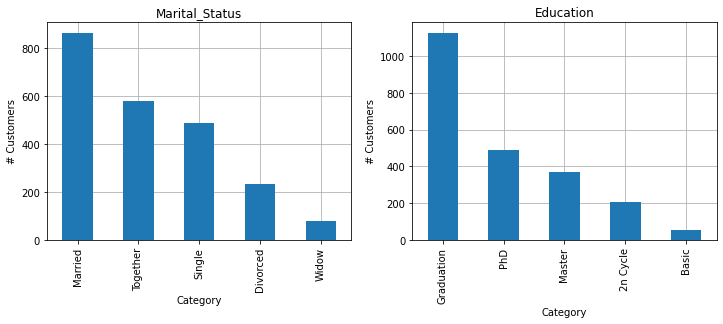

In [14]:
def barPlotCategoryDistribution(df: pd.DataFrame, *cols: str):
    _, axes = plt.subplots(1, len(cols), figsize=(len(cols)*6, 4))
    for a, col in zip(axes if len(cols) > 1 else (axes,), cols):
        a.set_title(col)
        a.set_xlabel('Category')
        a.set_ylabel('# Customers')
        a = df[col].value_counts().plot(kind="bar", ax=a, grid=True, zorder=3)
        a.grid(zorder=0)
        a.plot()
    
barPlotCategoryDistribution(dataDf, DataColumn.MARITAL_STATUS, DataColumn.EDUCATION)

We also notice that all `Z_CostContact` and `Z_Revenue` cells have the same values:

In [15]:
dataDf[DataColumn.Z_COSTCONTACT].unique(), dataDf[DataColumn.Z_REVENUE].unique()

(array([3]), array([11]))

Therefore we can drop them entirely:

In [16]:
dataDf.drop(columns=[DataColumn.Z_COSTCONTACT, DataColumn.Z_REVENUE], inplace=True)

### **Q3**: Generating new features

**A.** Adding a new `Customer_For` feature using the `Dt_Customer` and `Recency` features

In [17]:
def extractCustomerTime(args: Tuple[int, datetime]):
    daysSince, startDate = args
    recencyDate = datetime.now() - timedelta(days=daysSince)
    return (recencyDate - startDate).days

dataDf[DataColumn.CUSTOMER_FOR] = dataDf[[DataColumn.RECENCY, DataColumn.DT_CUSTOMER]].apply(
    lambda args: extractCustomerTime(tuple(args)),
    axis=1
)

**B.** Adding a new `Age` column based on `Year_Birth` column:

In [18]:
dataDf[DataColumn.AGE] = date.today().year - dataDf[DataColumn.YEAR_BIRTH]

**C.** Creating a new `Spent` column, which is the sum of `MntWines`, `MntFruits`, `MntMeatProducts`, `MntFishProducts`, `MntSweetProducts` & `MntGoldProds` columns

In [19]:
mntCols = [
    DataColumn.MNTWINES,
    DataColumn.MNTFRUITS,
    DataColumn.MNTMEATPRODUCTS,
    DataColumn.MNTFISHPRODUCTS,
    DataColumn.MNTSWEETPRODUCTS,
    DataColumn.MNTGOLDPRODS
]
dataDf[DataColumn.SPENT] = dataDf[mntCols].sum(axis=1)

**D.** Adding a new `Children_Total` column, which is the sum of `Kidhome` and `Teenhome` columns

In [20]:
dataDf[DataColumn.CHILDREN_TOTAL] = dataDf[[DataColumn.KIDHOME, DataColumn.TEENHOME]].sum(axis=1)

**F.** Generating a new `Is_Parent` feature, based on the `Children_Total` feature.

In [21]:
dataDf[DataColumn.IS_PARENT] = dataDf[DataColumn.CHILDREN_TOTAL].map(lambda total: int(total > 0))

**G.** Generating a new `Living_With` feature, based on the `Marital_Status` feature.

In [22]:
class LivingWithStatus(str, TitlecasedStrEnum):
    PARTNER = auto()
    ALONE = auto()

def mapMaritalStatusToLivingWith(ms: MaritalStatus):
    if ms == MaritalStatus.MARRIED or ms == MaritalStatus.TOGETHER:
        return LivingWithStatus.PARTNER.value
    return LivingWithStatus.ALONE.value

dataDf[DataColumn.LIVING_WITH] = dataDf[DataColumn.MARITAL_STATUS].map(mapMaritalStatusToLivingWith)
dataDf[[DataColumn.LIVING_WITH, DataColumn.MARITAL_STATUS]].head(n=8)

,Living_With,Marital_Status
0,Alone,Single
1,Alone,Single
2,Partner,Together
3,Partner,Together
4,Partner,Married
5,Partner,Together
6,Alone,Divorced
7,Partner,Married


**E.** Generating a new `Family_Size` feature, based on `Children_Total` & `Living_With` (**Q3.G**) features.

In [23]:
def findFamilySize(args: Tuple[int, LivingWithStatus]):
    childrenTotal, livingWith = args
    return childrenTotal + int(livingWith == LivingWithStatus.PARTNER) + 1

dataDf[DataColumn.FAMILY_SIZE] = dataDf[[DataColumn.CHILDREN_TOTAL, DataColumn.LIVING_WITH]].apply(
    lambda args: findFamilySize(tuple(args)),
    axis=1
)
dataDf[[DataColumn.FAMILY_SIZE, DataColumn.LIVING_WITH, DataColumn.CHILDREN_TOTAL]].head(n=8)

,Family_Size,Living_With,Children_Total
0,1,Alone,0
1,3,Alone,2
2,2,Partner,0
3,3,Partner,1
4,3,Partner,1
5,3,Partner,1
6,2,Alone,1
7,3,Partner,1


**H.** Generating a new `Age_Group` column, based on the `Age` column.

In [24]:
class AgeGroups:
    groupLimits = [
        21,
        30,
        40,
        50,
        60,
        70,
        80
    ]
    assert groupLimits == sorted(groupLimits)

    @staticmethod
    def getAgeGroupStrings():
        groups: List[str] = []
        for i, gl in enumerate(AgeGroups.groupLimits):
            if i == 0:
                groups.append(f'<{gl}')
                if len(AgeGroups.groupLimits) > 1:
                    groups.append(f'{gl}-{AgeGroups.groupLimits[i + 1]}')
                continue

            if i < len(AgeGroups.groupLimits) - 1:
                groups.append(f'{gl + 1}-{AgeGroups.groupLimits[i + 1]}')
        
        groups.append(f'>{AgeGroups.groupLimits[-1]}')
        return groups

    @staticmethod
    def mapAgeToAgeGroup(age: int):
        for i, gl in enumerate(AgeGroups.groupLimits):
            if age <= gl:
                if i > 0:
                    return f'{AgeGroups.groupLimits[i-1] + 1}-{gl}'
                else:
                    return f'<{gl}'
        
        return f'>{AgeGroups.groupLimits[-1]}'

dataDf[DataColumn.AGE_GROUP] = dataDf[DataColumn.AGE].map(AgeGroups.mapAgeToAgeGroup)
dataDf[[DataColumn.AGE_GROUP, DataColumn.AGE]].head(n=8)

,Age_Group,Age
0,61-70,66
1,61-70,69
2,51-60,58
3,31-40,39
4,41-50,42
5,51-60,56
6,51-60,52
7,31-40,38


In [25]:
AgeGroups.getAgeGroupStrings()

['<21', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '>80']

### **Q4**: Detecting & Removing outlier values

Before removing any rows, the shape of the `DataFrame` is:

In [26]:
dataDf.shape

(2240, 35)

We can easily spot columns with outliers using **boxplots**. Boxplots provide a quick glance at the data distribution, allowing us to discover features with values that vastly abstain from the common ones.

In [27]:
def boxPlotCols(df: pd.DataFrame, cols: Sequence[str]):
    if len(cols):
        _, axes = plt.subplots(1, len(cols), figsize=(len(cols)*6, 4))
        for i, col in enumerate(cols):
            axes[i].set_title(col)
            sns.boxplot(data=df[col], ax=axes[i])

After examining the box plots for each feature, we decided to remove rows with outlier `Age`, `Spent` & `Income` values.

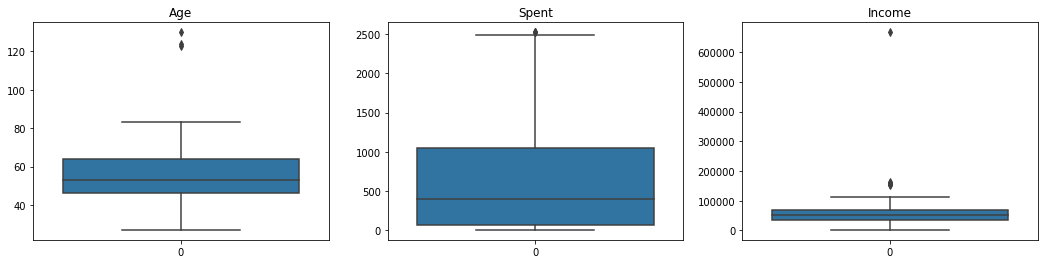

In [28]:
outlierCols = (
    DataColumn.AGE,
    DataColumn.SPENT,
    DataColumn.INCOME,
    # DataColumn.MNTWINES,
    # DataColumn.MNTFISHPRODUCTS,
    # DataColumn.MNTFRUITS,
    # DataColumn.MNTGOLDPRODS,
    # DataColumn.MNTSWEETPRODUCTS,
    # DataColumn.MNTMEATPRODUCTS
)
        
boxPlotCols(dataDf, outlierCols)

We eliminate the outliers using the IQR (Inter Quartile Range) method.
See also:
- https://www.geeksforgeeks.org/detect-and-remove-the-outliers-using-python/
- https://towardsdatascience.com/why-1-5-in-iqr-method-of-outlier-detection-5d07fdc82097

In [29]:
def removeColumnOutliers(df: pd.DataFrame, col: str):
    q1 = np.percentile(df[col], q=25, interpolation='midpoint')
    q3 = np.percentile(df[col], q=75, interpolation='midpoint')
    iqr = q3 - q1

    floor = q3 - 1.5 * iqr
    ceil = q3 + 1.5 * iqr

    df.drop( df.loc[~df[col].between(left=floor, right=ceil)].index, inplace=True )
    df.reset_index(inplace=True, drop=True)

for col in outlierCols:
    removeColumnOutliers(dataDf, col)

After removing outlier rows, the shape of the `DataFrame` is:

In [30]:
dataDf.shape

(1975, 35)

We can also verify the effect of the outliers removal by revisiting the boxplots of the target columns:

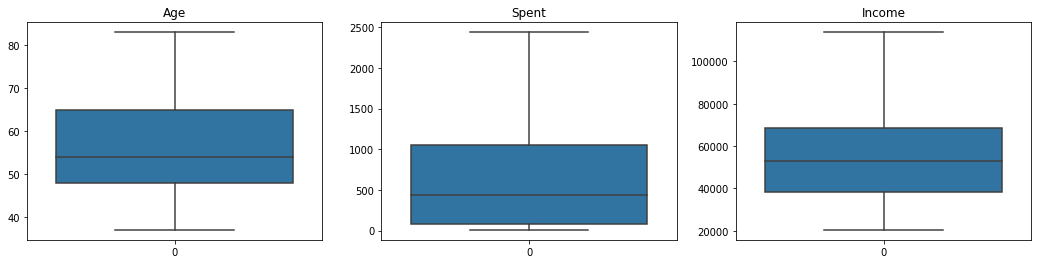

In [31]:
boxPlotCols(dataDf, outlierCols)

**Q5.** Presenting the relationships between (numeric) features using a **heatmap**.\
We exclude the following features:
- `ID`, since it is not valuable information
- `Year_Birth`, since it is represented by `Age`
- `Is_Parent`, `Kidhome` and `Teenhome`, since they are represented by `Children_Total`

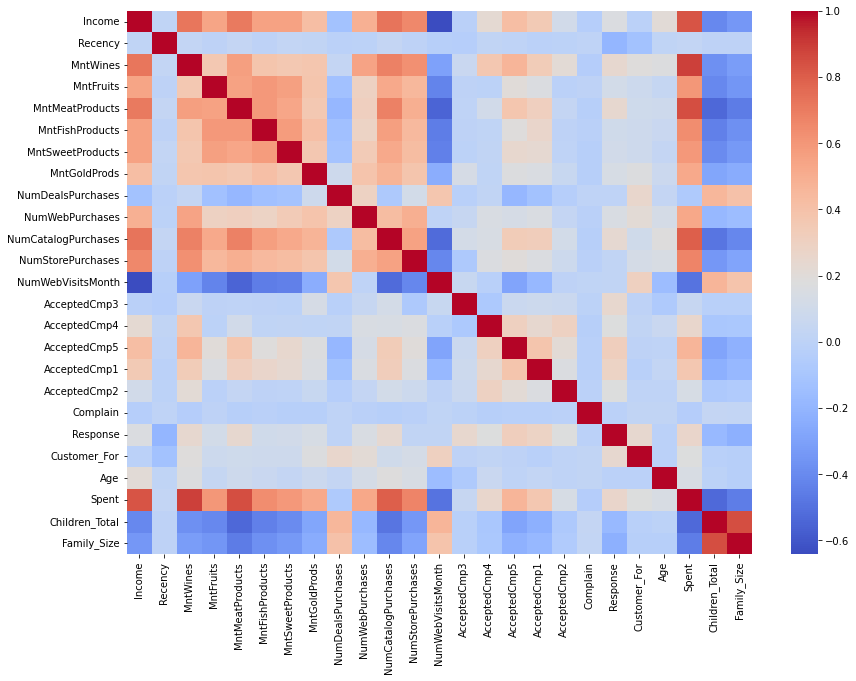

In [32]:
excludeCols = [
    DataColumn.ID,
    DataColumn.YEAR_BIRTH,
    DataColumn.KIDHOME,
    DataColumn.TEENHOME,
    DataColumn.IS_PARENT,
    
    # DataColumn.ACCEPTEDCMP1,
    # DataColumn.ACCEPTEDCMP2,
    # DataColumn.ACCEPTEDCMP3,
    # DataColumn.ACCEPTEDCMP4,
    # DataColumn.ACCEPTEDCMP5,
    # DataColumn.MNTFISHPRODUCTS,
    # DataColumn.MNTFRUITS,
    # DataColumn.MNTGOLDPRODS,
    # DataColumn.MNTMEATPRODUCTS,
    # DataColumn.MNTSWEETPRODUCTS,
    # DataColumn.MNTWINES,
    # DataColumn.NUMCATALOGPURCHASES,
    # DataColumn.NUMDEALSPURCHASES,
    # DataColumn.NUMWEBPURCHASES,
    # DataColumn.NUMSTOREPURCHASES,
    # DataColumn.NUMWEBVISITSMONTH,
    # DataColumn.COMPLAIN,
    # DataColumn.RESPONSE
]

dfView = dataDf.select_dtypes(include=['int64', 'float64']).drop(excludeCols, axis=1)
_, axes = plt.subplots(1, 1, figsize=(14,10))
drawHeatmap(dfView, axes)

**Interpreting a heatmap**

A heatmap visualizes the correlation between each 2 features of the dataset:
- A value closer to **1.0** means there is a **linear (proportional)** trend between the features: when `feature_1` value increases, `feature_2` value tends to increase (at least in some degree). This also explains why the diagonal values are all equal to 1.0 (each feature is linearly realted to itself).
- A value closer to **-1.0** means there is an **inverse proportional** relatioship, therefore `feature_1` value tends to decrease when `feature_2` value increases.
- A value closer to **0** means there is no linear relationship between the 2 features.

### **Q6**. Answering questions using plots/graphs

**Q6.1**. Below we can see the number of customers assigned to each `Marital_Status` category:

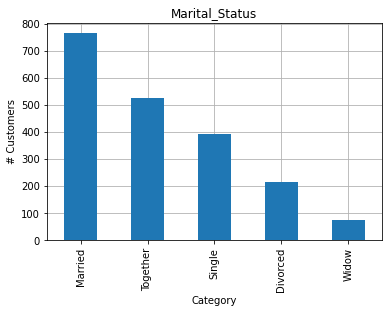

In [33]:
barPlotCategoryDistribution(dataDf, DataColumn.MARITAL_STATUS)

In [34]:
topMaritalStatus = dataDf[DataColumn.MARITAL_STATUS].mode()[0]
printMd(f'We can see the most frequent `{DataColumn.MARITAL_STATUS}` value is `"{topMaritalStatus}"`')

We can see the most frequent `Marital_Status` value is `"Married"`

**Q6.2**. Below we can see the how many customers have (or have not) complained:

In total, **17 customers** have complained at least once.

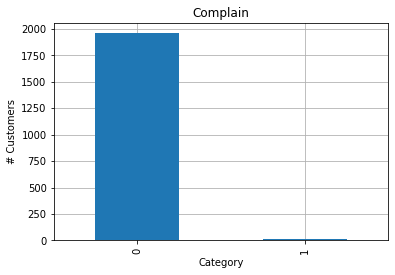

In [35]:
totalComplaints = (dataDf[DataColumn.COMPLAIN] == 1).value_counts()[1]
printMd(f'In total, **{totalComplaints} customers** have complained at least once.')
barPlotCategoryDistribution(dataDf, DataColumn.COMPLAIN)

**Q6.3,4,5,6** Examining the relationship between the `Spent` feature and the following:
- `Marital_Status`
- `Children_Total`
- `Family_Size`
- `Age_Group`
- `Income`

First, we examine the `Children_Total`, `Family_Size` & `Income` features, since they are numerical and convenient to generate a **heatmap**:

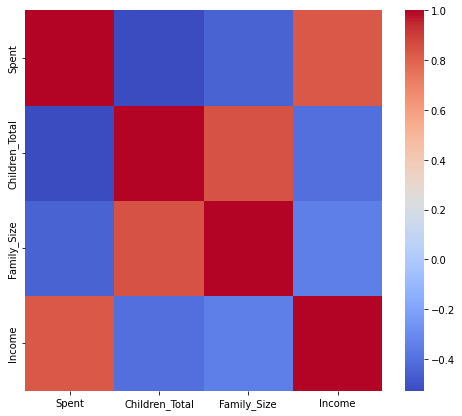

In [36]:
includeCols = [
    DataColumn.SPENT,
    DataColumn.CHILDREN_TOTAL,
    DataColumn.FAMILY_SIZE,
    DataColumn.INCOME
]

dfView = dataDf[includeCols]
_, axes = plt.subplots(1, 1, figsize=(8,7))
drawHeatmap(dfView, axes)

As we expected, `Spent` and `Income` features are tightly related: when `Income` increases/decreases, `Spent` increases/decreases respectively.\
Surprisingly though (according to the dataset), increasing the number of children (`Children_Total`) and, consequently, the total size of the family (`Family_Size`) will likely not increase the total amount spent. In fact, it is more likely that `Spent` will be (slightly) decreased(!).

To create a heatmap for `Spent` and the other 2 features (`Marital_Status` & `Age_Group`), we first use **one-hot encoding** to convert each categorical column into **many 0/1 indicator columns** (one for each possible category value).\
To one-hot encode, we use `pd.get_dummies` as an alternative to `sklearn.preprocessing.OneHotEncoder`, since it includes the original `str` value of each category in the respective generated column title, making the heatmap easier to interpret.

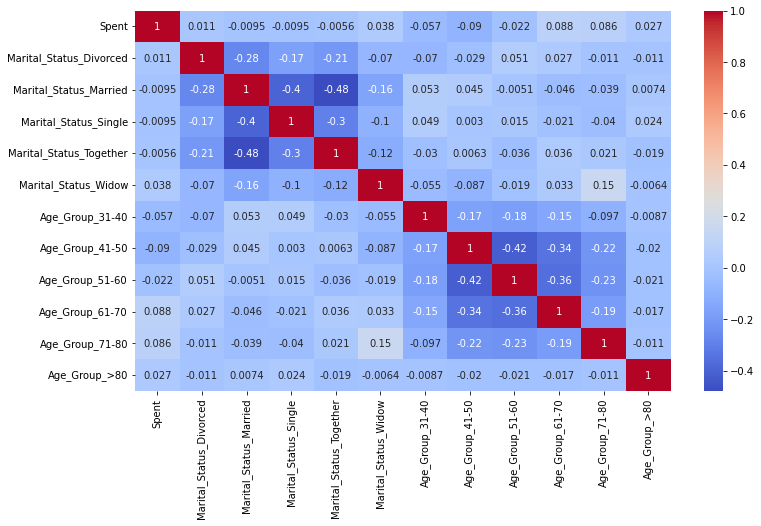

In [37]:
includeCols = [
    DataColumn.SPENT,
    DataColumn.MARITAL_STATUS,
    DataColumn.AGE_GROUP
]

tempDf = pd.get_dummies(data=dataDf[includeCols], columns=[DataColumn.MARITAL_STATUS, DataColumn.AGE_GROUP])
_, axes = plt.subplots(1, 1, figsize=(12,7))
drawHeatmap(tempDf, axes, annot=True)

Using the heatmap above we can conclude that we cannot assume anything about the `Spent` value based on the `Marital_Status` or the `Age_Group`, since all the `Spent` - `<column category>` values are close to 0.

We are about to answer several questions by plotting histograms for dataset columns.\
The code below will help us automate this process.

In [38]:
class HistogramQuestionData(TypedDict):
    """ Used to store question-specific information. """
    qnum: str
    """ Question Number. """
    col: str
    """ Column title. """
    xlabel: str
    """ x-axis label. """

class HistogramAnswerGenerator:
    """ Used to generate histogram answers. """
    def __init__(self) -> None:
        self.questions: List[HistogramQuestionData] = []

    def registerQuestions(self, questions: Iterable[HistogramQuestionData]):
        self.questions = list(questions)
        return self

    def registerQuestion(self, q: HistogramQuestionData):
        self.questions.append(q)
        return self

    def clearQuestions(self):
        self.questions.clear()
        return self
    
    @staticmethod
    def displayColumnHistogram(df: pd.DataFrame, col: str, xlabel: str, ylabel: str = '# Customers'):
        ax = plt.subplot()
        ax.set_title(col)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        df[col].hist(ax=ax, grid=True, zorder=3)

    def generateAnswers(self, df: pd.DataFrame):
        for q in self.questions:
            printMd(f'**{q["qnum"]}**. Below we can see the `{q["col"]}` column histogram:')
            self.displayColumnHistogram(df, q['col'], xlabel=q['xlabel'])
            plt.show()

Generating answers:

**Q6.14**. Below we can see the `NumDealsPurchases` column histogram:

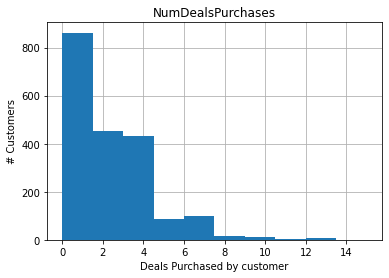

**Q6.15**. Below we can see the `Income` column histogram:

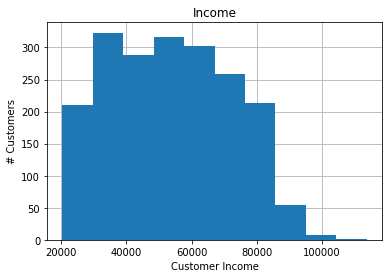

**Q6.16**. Below we can see the `Kidhome` column histogram:

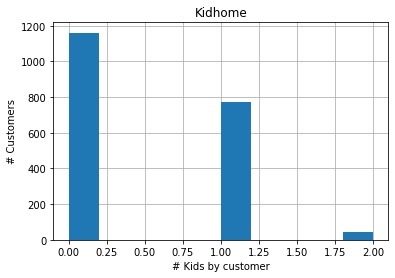

**Q6.17**. Below we can see the `Family_Size` column histogram:

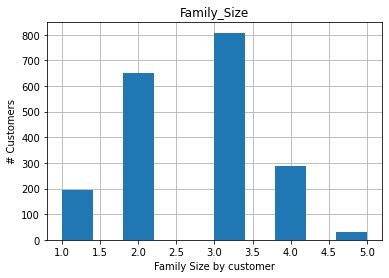

In [39]:
questions: List[HistogramQuestionData] = [
    {
        'qnum': 'Q6.14',
        'col': DataColumn.NUMDEALSPURCHASES,
        'xlabel': 'Deals Purchased by customer'
    },
    {
        'qnum': 'Q6.15',
        'col': DataColumn.INCOME,
        'xlabel': 'Customer Income'
    },
    {
        'qnum': 'Q6.16',
        'col': DataColumn.KIDHOME,
        'xlabel': '# Kids by customer'
    },
    {
        'qnum': 'Q6.17',
        'col': DataColumn.FAMILY_SIZE,
        'xlabel': 'Family Size by customer'
    },
]

HistogramAnswerGenerator().registerQuestions(questions).generateAnswers(dataDf)

### **Q7**: Principal Component Analysis

In [40]:
oneHotCols = [
    DataColumn.AGE_GROUP,
    DataColumn.EDUCATION,
    DataColumn.MARITAL_STATUS,
    DataColumn.LIVING_WITH
]
colsToDrop = [
    DataColumn.ACCEPTEDCMP1,
    DataColumn.ACCEPTEDCMP2,
    DataColumn.ACCEPTEDCMP3,
    DataColumn.ACCEPTEDCMP4,
    DataColumn.ACCEPTEDCMP5,
    DataColumn.RESPONSE,
    DataColumn.COMPLAIN,

    DataColumn.ID,
    DataColumn.DT_CUSTOMER
]
dfOneHot = pd.get_dummies(data=dataDf, columns=oneHotCols)
dfOneHot.drop(columns=colsToDrop, inplace=True)
dfOneHot.columns

Index(['Year_Birth', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'MntWines',
       'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth',
       'Customer_For', 'Age', 'Spent', 'Children_Total', 'Is_Parent',
       'Family_Size', 'Age_Group_31-40', 'Age_Group_41-50', 'Age_Group_51-60',
       'Age_Group_61-70', 'Age_Group_71-80', 'Age_Group_>80',
       'Education_2n Cycle', 'Education_Basic', 'Education_Graduation',
       'Education_Master', 'Education_PhD', 'Marital_Status_Divorced',
       'Marital_Status_Married', 'Marital_Status_Single',
       'Marital_Status_Together', 'Marital_Status_Widow', 'Living_With_Alone',
       'Living_With_Partner'],
      dtype='object')

In [41]:
def standarizeColumn(col: pd.DataFrame):
    return (col - col.mean()) / col.std()

for col in dfOneHot.columns:
    dfOneHot[col] = standarizeColumn(dfOneHot[col])

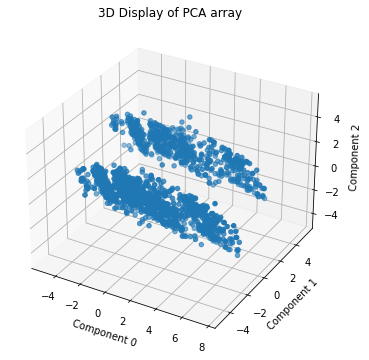

In [42]:
N_COMPONENTS = 3
pcaCompressor = PCA(n_components=N_COMPONENTS)
pcaArray = pcaCompressor.fit_transform(dfOneHot)

def plot3dPca(arr: np.ndarray):
    assert arr.shape[1] == 3

    fig = plt.figure(figsize=(7, 6))
    ax = fig.add_subplot(projection='3d')
    ax.scatter3D(xs=arr[:,0], ys=arr[:,1], zs=arr[:,2])

    ax.set_title('3D Display of PCA array')
    ax.set_xlabel('Component 0')
    ax.set_ylabel('Component 1')
    ax.set_zlabel('Component 2')

plot3dPca(pcaArray)

### **Q8.** Clustering Implementation

           0/14 -- Time Elapsed: 00:00

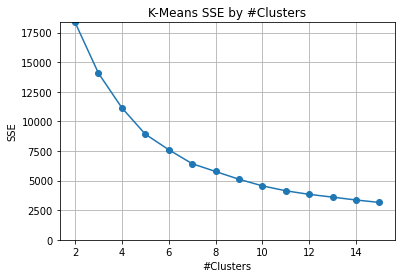

           0/14 -- Time Elapsed: 00:00

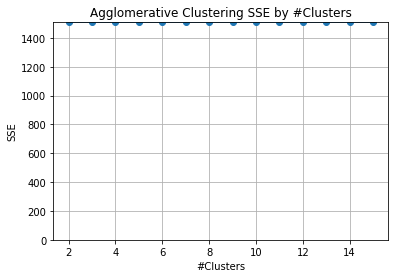

In [46]:
@dataclass
class ClustererWrapper:
    cls: Type["KMeans | AgglomerativeClustering"]
    clsName: str

    def init(self, nClusters: int):
        if self.cls == KMeans:
            self.__clusterer__ = self.cls(n_clusters=nClusters)
        elif self.cls == AgglomerativeClustering:
            self.__clusterer__ = self.cls(n_clusters=nClusters, compute_distances=True)
    
    def fit(self, data: np.ndarray):
        self.__clusterer__.fit(data)

    def computeError(self):
        if self.cls == KMeans:
            return self.__clusterer__.inertia_
        elif self.cls == AgglomerativeClustering:
            distances: Iterable[float] = self.__clusterer__.distances_
            return sum(math.sqrt(d) for d in distances)

def fitClusterer(clusterer: ClustererWrapper, data: np.ndarray, verbose: bool = True):
    iterRange = range(K_MIN, K_MAX + 1)
    if verbose:
        iterator = tqdm(
            iterRange,
            bar_format='{desc}{bar} {n}/{total} -- Time Elapsed: {elapsed}'
        )
    else:
        iterator = iterRange

    errorByK = []
    for k in iterator:
        clusterer.init(nClusters=k)
        clusterer.fit(data)
        errorByK.append(clusterer.computeError())

        if verbose:
            iterator.set_description(f"Fitting {clusterer.clsName} with k = {k:<3}")

    return list(iterRange), errorByK

def demonstrateClusterer(clusterer: ClustererWrapper, data: np.ndarray, verbose: bool = True):
    kSizes, errors = fitClusterer(clusterer, data, verbose)
    ax = plt.subplot()
    ax.set_title(f'{clusterer.clsName} SSE by #Clusters')
    ax.set_ylabel('SSE')
    ax.set_ylim(0, max(errors))
    ax.set_xlabel('#Clusters')
    ax.grid(visible=True)
    ax.plot(kSizes, errors, marker='o')
    plt.show()
    
clusterers = (
    ClustererWrapper(cls=KMeans, clsName='K-Means'),
    ClustererWrapper(cls=AgglomerativeClustering, clsName='Agglomerative Clustering')
)

for wrapper in clusterers:
    demonstrateClusterer(wrapper, pcaArray, verbose=VERBOSE_CLUSTERING)